## Step 0. Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import random
import cv2
from keras.datasets import mnist
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import *
import utils
import os
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from matplotlib.image import imread
from keras.models import Sequential
from keras.layers import *
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from statistics import mean
from typing import *

## Step 1. Examine and load the test/train data

In [7]:
%%bash
mkdir -p raw_data

In [6]:
%%bash
ls /Users/jiz/Downloads/DeepLearning/*.zip

/Users/jiz/Downloads/DeepLearning/test_encoded.zip
/Users/jiz/Downloads/DeepLearning/train.zip


In [8]:
%%bash
mv /Users/jiz/Downloads/DeepLearning/*.zip raw_data/

In [15]:
%%bash
ls raw_data/*.zip|while read zipf; do
    unzip $zipf >> /dev/null 2>&1
done

In [17]:
%%bash
ls .

__MACOSX
kerasLayers_Test.ipynb
raw_data
test_encoded
train


In [24]:
%%bash
ls test_encoded/
echo -e "\n"
ls train/

NORMAL
PNEUMONIA


NORMAL
PNEUMONIA


### Obtain the size of training data and test data

In [29]:
%%bash
echo "test_encoded"
ls test_encoded/|while read class; do 
    echo $class && ls test_encoded/$class|wc -l
done

echo "train"
ls train/|while read class; do
    echo $class && ls train/$class|wc -l
done

test_encoded
NORMAL
      30
PNEUMONIA
      21
train
NORMAL
    1341
PNEUMONIA
    1341


### Obtain the format of training/test data

In [43]:
%%bash
ls train/NORMAL/*|head -n5
ls train/PNEUMONIA/*|head -n9

train/NORMAL/IM-0115-0001.jpeg
train/NORMAL/IM-0117-0001.jpeg
train/NORMAL/IM-0119-0001.jpeg
train/NORMAL/IM-0122-0001.jpeg
train/NORMAL/IM-0125-0001.jpeg
train/PNEUMONIA/person1000_bacteria_2931.jpeg
train/PNEUMONIA/person1001_bacteria_2932.jpeg
train/PNEUMONIA/person1002_bacteria_2933.jpeg
train/PNEUMONIA/person1004_bacteria_2935.jpeg
train/PNEUMONIA/person1005_bacteria_2936.jpeg
train/PNEUMONIA/person1006_bacteria_2937.jpeg
train/PNEUMONIA/person1007_bacteria_2938.jpeg
train/PNEUMONIA/person1010_bacteria_2941.jpeg
train/PNEUMONIA/person1011_bacteria_2942.jpeg


### Visualize the train images

In [2]:
pneumonia_top9_imgs: List[str] = [
    "train/PNEUMONIA/person1000_bacteria_2931.jpeg",
    "train/PNEUMONIA/person1001_bacteria_2932.jpeg",
    "train/PNEUMONIA/person1002_bacteria_2933.jpeg",
    "train/PNEUMONIA/person1004_bacteria_2935.jpeg",
    "train/PNEUMONIA/person1005_bacteria_2936.jpeg",
    "train/PNEUMONIA/person1006_bacteria_2937.jpeg",
    "train/PNEUMONIA/person1007_bacteria_2938.jpeg",
    "train/PNEUMONIA/person1010_bacteria_2941.jpeg",
    "train/PNEUMONIA/person1011_bacteria_2942.jpeg"
]

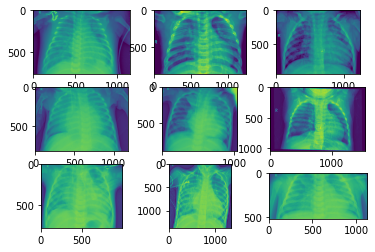

In [3]:
# define location of dataset
pneumonia_folder = 'train/PNEUMONIA'
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(3, 3, i+1)
    # define filename
    filename = pneumonia_top9_imgs[i]
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

In [32]:
%%bash
ls test_encoded/NORMAL/*|head -n5
ls test_encoded/PNEUMONIA/*|head -n5

test_encoded/NORMAL/_0_793163.txt
test_encoded/NORMAL/_10_2309560.txt
test_encoded/NORMAL/_10_4614217.txt
test_encoded/NORMAL/_11_2646888.txt
test_encoded/NORMAL/_12_3260859.txt
test_encoded/PNEUMONIA/_0_2894513.txt
test_encoded/PNEUMONIA/_11_7509739.txt
test_encoded/PNEUMONIA/_12_7226461.txt
test_encoded/PNEUMONIA/_13_8376919.txt
test_encoded/PNEUMONIA/_14_4289383.txt


### Test a glimpse at how the test <code>.txt</code> files would actually look like

In [34]:
%%bash 
cat test_encoded/NORMAL/_0_793163.txt|head -n1
wc -l test_encoded/NORMAL/_0_793163.txt

3.900000000000000000e+01 3.900000000000000000e+01 4.800000000000000000e+01 4.600000000000000000e+01 5.100000000000000000e+01 9.300000000000000000e+01 1.170000000000000000e+02 9.400000000000000000e+01 8.600000000000000000e+01 8.700000000000000000e+01 8.300000000000000000e+01 8.900000000000000000e+01 8.600000000000000000e+01 9.500000000000000000e+01 9.900000000000000000e+01 1.210000000000000000e+02 1.250000000000000000e+02 9.100000000000000000e+01 6.300000000000000000e+01 6.300000000000000000e+01 6.000000000000000000e+01 6.500000000000000000e+01 5.900000000000000000e+01 5.400000000000000000e+01 5.800000000000000000e+01 5.500000000000000000e+01 5.800000000000000000e+01 5.600000000000000000e+01 6.000000000000000000e+01 5.500000000000000000e+01 5.500000000000000000e+01 5.700000000000000000e+01 5.700000000000000000e+01 5.800000000000000000e+01 5.200000000000000000e+01 4.700000000000000000e+01 4.600000000000000000e+01 4.200000000000000000e+01 3.600000000000000000e+01 3.000000000000000000e+01 

In [38]:
%%bash
head -n1 test_encoded/NORMAL/_0_793163.txt|tr " " "\n"|wc -l

     224


### As a conclusion, each test <code>.txt</code> file represents a one-channel image at a resolution of 224x2224

### Therefore, we would have to write a function to read train and test images from OS using either <hr /><code>ImageDataGenerator</code> or <code>numpy.array</code>

In [2]:
#Specifying the image
Image_Width=224
Image_Height=224
Batch_Size = 32
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

returns to a tuple of two ImageDataIterators, which consists of the augmented train iterator and the non-augmented test iterator

A tutorial for <code>ImageDataGenerator.flow</code> to generate an ImageDataFlow from Numpy arrays: https://theailearner.com/2019/07/06/imagedatagenerator-flow-method/

In [3]:
def process_input_data(
    input_path:str="", 
    img_width:int=Image_Width, img_height:int=Image_Height, img_channels:int=Image_Channels,
    batch_size:int=Batch_Size
) -> Tuple[any]:
    
    # input parameter assertions
    assert img_width >= 16 and img_height>=16
    assert img_channels in {1, 3, 4}
    assert 16<=batch_size<=256
    
    # ImageDataGenerator objects
    train_datagen = ImageDataGenerator(
        rescale=1./255, 
        rotation_range=45, fill_mode='nearest', 
        brightness_range = (0.8, 1.25),
        zoom_range= (0.8, 1.25),
        width_shift_range=0.2, height_shift_range=0.2,
        channel_shift_range=50
    )
    
    # only rescaling
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_iterator = train_datagen.flow_from_directory(
        directory=input_path+'train', 
        target_size=(img_width, img_height), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True
    )

    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data: List[np.ndarray] = []
    test_labels: List[int] = []

    for cond in ('/NORMAL/', '/PNEUMONIA/'):
        for img_fname in (os.listdir(f"{input_path}test_encoded{cond}")):
            """
            Reads the text files into numpy arrays.
            PNG images are returned as float arrays (0-1). 
            All other formats are returned as int arrays, with a bit depth determined by the file's contents.
            """
            txt_fname = f"{input_path}test_encoded{cond}{img_fname}"
            raw_img_array = pd.read_csv(txt_fname, header=None, sep=" ").to_numpy()
            greyscale_img_array = cv2.resize(raw_img_array, (img_width, img_height))
            # converts one-channel images into three channel images
            rgb_img_array = cv2.merge([greyscale_img_array]*3)
            rgb_img_array = rgb_img_array.astype('float32')
            label = 0 if cond=="/NORMAL/" else 1
            test_data.append(rgb_img_array)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    test_iterator = test_datagen.flow(
        test_data, test_labels, 
        batch_size=batch_size, 
        shuffle=True
    )
    
    return train_iterator, test_iterator

In [4]:
train_iterator, test_iterator = process_input_data()

Found 2682 images belonging to 2 classes.


In [5]:
print(type(train_iterator), type(test_iterator))

<class 'keras.preprocessing.image.DirectoryIterator'> <class 'keras.preprocessing.image.NumpyArrayIterator'>


In [8]:
print(train_iterator.filenames[:3], train_iterator.filenames[-3:], len(train_iterator.filenames))

['NORMAL/IM-0115-0001.jpeg', 'NORMAL/IM-0117-0001.jpeg', 'NORMAL/IM-0119-0001.jpeg'] ['PNEUMONIA/person998_bacteria_2927.jpeg', 'PNEUMONIA/person9_bacteria_38.jpeg', 'PNEUMONIA/person9_bacteria_39.jpeg'] 2682


In [9]:
print(train_iterator.labels[:3], train_iterator.labels[-3:], len(train_iterator.labels))

[0 0 0] [1 1 1] 2682


Therefore, we could know that Normal=0 and Pneumonia=1

## Step 2. Train and test a CNN model that directly uses objects at <code>keras.layers.*</code> 
This test is only for test due to the ban on using predefined layers, we would have to write our own layers using <code>keras.backend</code> later)

In [6]:
"""
Define the CNN model with 92% accuracy that we used in the Dog VS Cat Project
Returns to tf.keras.Sequential
"""

def create_CNN_Model(Image_size: tuple, Image_channels=3) -> tf.keras.Sequential:
    assert len(Image_Size)==2 and Image_Size[0]>0 and Image_Size[1]>0, "Image_size must be a tuple of two positive integers!"
    model=Sequential()
    model.add(Conv2D(32,(3,3),activation='relu', kernel_initializer=keras.initializers.he_uniform(seed=42), input_shape=(Image_Width,Image_Height,Image_Channels)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64,(3,3), kernel_initializer=keras.initializers.he_uniform(seed=42), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128,(3,3), kernel_initializer=keras.initializers.he_uniform(seed=42), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(256,(3,3), kernel_initializer=keras.initializers.he_uniform(seed=42), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512,activation='relu', kernel_regularizer=keras.regularizers.L2(5e-3)))
    model.add(Dense(1,activation='sigmoid'))
    return model

model = create_CNN_Model(Image_size=Image_Size)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                        

In [55]:
def fitted_model(model: Sequential, lr: float, train_imgs: keras.preprocessing.image.DirectoryIterator, val_imgs: keras.preprocessing.image.NumpyArrayIterator) -> Tuple:
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=["accuracy"])
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='weights.best.inc.blond.hdf5', verbose=1, save_best_only=True)
    model_history = model.fit(train_imgs, validation_data=val_imgs, steps_per_epoch=len(train_imgs), validation_steps=len(val_imgs), epochs=10, callbacks=[checkpointer])
    return (model, model_history)

In [56]:
training_history: Dict[str, List[float]] = {}
for his_key in ('loss', 'accuracy', 'val_loss', 'val_accuracy'):
    training_history[his_key] = [] 

acc_per_100_epochs: List[float] = []

# first 50% epochs: 2e-3, 50%-80% epochs: 5e-4, 80%-100% epochs: 1e-4
def obtain_lr(initial_lr: float, total_epochs: int, round_index: int, epochs_per_round: int) -> float:
    assert total_epochs>=10 and total_epochs%10==0, "The number of datasets must be divsible by 10!"
    assert 0<(round_index*epochs_per_round)<=total_epochs
    return initial_lr if round_index*epochs_per_round<=total_epochs/2 else initial_lr/4 if round_index*epochs_per_round<=total_epochs*0.8 else initial_lr/20

# 100 epochs for each augmented dataset, maximally 500 epochs, stop training when the average validation accuracy of last 10 epochs becomes above 0.9
stop_training: bool = False
rounds_per_dataset: int = 10
for dataset_count in range(1, 6):
    if stop_training: break
    for round_count in range(1, rounds_per_dataset+1):
        lr = obtain_lr(2e-3, 100, round_count, 10)
        print(f'Learning rate for this round is: {str(lr)}')
        model, history = fitted_model(model, lr, train_iterator, test_iterator)
        for his_key in history.history.keys():
            training_history[his_key].extend(history.history[his_key])
        sliding_avg_10_acc: float = mean(training_history['val_accuracy'][-10:])
        if sliding_avg_10_acc > 0.9: 
            stop_training = True   
            break
    acc = model.evaluate(test_iterator, verbose=0)[1]
    print(f"Updated accuracy after using {str(dataset_count)} augmented training datasets: {round(acc, 4)*100}")
    model.save("pneumonia_aug_CNN.h5")

Learning rate for this round is: 0.002
Epoch 1/10
84/84 [==============================] - ETA: 0s - loss: 10.1324 - accuracy: 0.7994
Epoch 1: val_loss improved from inf to 16.46479, saving model to weights.best.inc.blond.hdf5
84/84 [==============================] - 46s 543ms/step - loss: 10.1324 - accuracy: 0.7994 - val_loss: 16.4648 - val_accuracy: 0.4118
Epoch 2/10
84/84 [==============================] - ETA: 0s - loss: 3.1712 - accuracy: 0.8594
Epoch 2: val_loss did not improve from 16.46479
84/84 [==============================] - 35s 415ms/step - loss: 3.1712 - accuracy: 0.8594 - val_loss: 20.4864 - val_accuracy: 0.4118
Epoch 3/10
84/84 [==============================] - ETA: 0s - loss: 2.0230 - accuracy: 0.8501
Epoch 3: val_loss did not improve from 16.46479
84/84 [==============================] - 35s 417ms/step - loss: 2.0230 - accuracy: 0.8501 - val_loss: 24.4271 - val_accuracy: 0.4118
Epoch 4/10
84/84 [==============================] - ETA: 0s - loss: 2.3946 - accuracy: 0.

#### We are able to obtain an accuracy at 96.08% using the built in layers (after 200 epochs of training), which is pretty high.

-----------------------------------------------------------------------------------------------------------------------------------------------------

### Step 3. Write our own convolutional, MaxPooling, and Dense layers using <code>keras.backend.*</code> 

Two of our self-written layers (<code>MyConv2D</code> and <code>DenseLayer</code>) are child classes of <b>tf.keras.layers.Layer</b> (<code>https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer</code>)

Convolutional Layer (to be updated)

In [90]:
class MyConv2D(tf.keras.layers.Layer):
    
    def __init__(self, kernel_initializer: tf.keras.initializers.Initializer, filters: int, kernel_size: Tuple[int] = (3, 3), activation:str='relu', **kwargs):
        # assertions for input params
        assert isinstance(filters, int) and filters > 0
        assert isinstance(kernel_size, tuple) and isinstance(kernel_initializer, tf.keras.initializers.Initializer) 
        assert len(kernel_size)==2 and kernel_size[0]>1 and kernel_size[1]>1
        assert isinstance(activation, str) and activation in {"relu", "sigmoid"}
        # class attribute assignment
        self.filters = filters
        self.kernel_size = kernel_size
        self.kernel_initializer = kernel_initializer
        self.activation = activation
        # call the constructor of the parent class of MyConv (tf.keras.layers.Layer)
        super(MyConv2D, self).__init__(**kwargs)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'kernel_initializer': self.kernel_initializer,
            'activation': self.activation
        })
        return config

    def build(self, input_shape):
        # assertions for input params
        assert len(input_shape) == 4
        # update the kernels of the 2D convolutional layer
        self.kernel = self.add_weight(name='kernel',
                                       shape= self.kernel_size + (input_shape[-1], self.filters),
                                       initializer = self.kernel_initializer,
                                       trainable=True)
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(name='bias',
                             initial_value=b_init(shape=(input_shape[1] - self.kernel_size[0] + 1, input_shape[2] - self.kernel_size[1] + 1) + (self.filters, )),
                             trainable=True)
        # call the .build() method of the parent class "Layer"
        super(MyConv2D, self).build(input_shape)

    def call(self, inputs):
        output = K.conv2d(inputs, self.kernel, data_format="channels_last")
        return tf.nn.relu(output + self.b) if self.activation=="relu" else tf.nn.sigmoid(output + self.b)

    def compute_output_shape(self, input_shape):
        return (input_shape[1] - self.kernel_size[0] + 1, input_shape[2] - self.kernel_size[1] + 1) + (self.filters, )
        

Max Pooling layer 

In [25]:
def max_pool2d(inputs):
    max_x =  K.pool2d(inputs, pool_size=(2, 2), strides=(2, 2))
    return max_x

def max_pool2d_output_shape(input_shape):
    shape = list(input_shape)
    if K.image_data_format() == 'channels_first':
        shape[2] /= 2
        shape[3] /= 2
    else:
        shape[1] /= 2
        shape[2] /= 2
    return tuple(shape)

def MyMaxPool2D() -> Lambda:
    return Lambda(function=max_pool2d, output_shape=max_pool2d_output_shape)

Dense layer

In [92]:
class MyDense(tf.keras.layers.Layer):
    def __init__(self, kernel_regularizer: tf.keras.regularizers.Regularizer=None, units:int=1, activation:str='relu', **kwargs):
        # assertions for input params
        assert isinstance(units, int) and units > 0
        assert isinstance(activation, str) and activation in {"relu", "sigmoid"}
        # class attribute assignment 
        self.units = units
        super(MyDense, self).__init__(**kwargs)
        self.kernel_regularizer = kernel_regularizer
        self.activation = activation

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'units': self.units,
            'kernel_regularizer': self.kernel_regularizer,
            'activation': self.activation
        })
        return config

    def build(self, input_shape):
        # assertions for input params
        assert len(input_shape) > 1
        # class attribute assignment 
        input_shape = tuple(input_shape)
        w_init = tf.random_normal_initializer()
        self.w = self.add_weight(name='kernel',  
                        shape=(input_shape[-1], self.units),
                        initializer='uniform',
                        regularizer=self.kernel_regularizer,
                        trainable=True)
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(name='bias',
                             initial_value=b_init(shape=(self.units, )),
                             trainable=True)
    
    def call(self, inputs):
        return tf.nn.relu(tf.matmul(inputs, self.w) + self.b) if self.activation=="relu" else tf.nn.sigmoid(tf.matmul(inputs, self.w) + self.b)

In [93]:
def create_self_CNN_Model(Image_size: tuple, Image_channels=3) -> tf.keras.Sequential:
    assert len(Image_Size)==2 and Image_Size[0]>0 and Image_Size[1]>0, "Image_size must be a tuple of two positive integers!"
    model=Sequential()
    model.add(MyConv2D(filters=32, activation='relu', kernel_initializer=keras.initializers.he_uniform(seed=42)))
    model.add(BatchNormalization())
    model.add(MyMaxPool2D())
    model.add(MyConv2D(filters=64, kernel_initializer=keras.initializers.he_uniform(seed=42), activation='relu'))
    model.add(BatchNormalization())
    model.add(MyMaxPool2D())
    model.add(MyConv2D(filters=128, kernel_initializer=keras.initializers.he_uniform(seed=42), activation='relu'))
    model.add(BatchNormalization())
    model.add(MyMaxPool2D())
    model.add(MyConv2D(filters=256, kernel_initializer=keras.initializers.he_uniform(seed=42), activation='relu'))
    model.add(BatchNormalization())
    model.add(MyMaxPool2D())
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(MyDense(units=512, kernel_regularizer=keras.regularizers.L2(5e-3)))
    model.add(MyDense(units=1, activation='sigmoid'))
    return model

own_model = create_self_CNN_Model(Image_size=Image_Size)
own_model.build((Batch_Size, Image_Width, Image_Height, Image_Channels))
own_model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_conv2d_27 (MyConv2D)     (32, 222, 222, 32)        1577952   
                                                                 
 batch_normalization_82 (Bat  (32, 222, 222, 32)       128       
 chNormalization)                                                
                                                                 
 lambda_81 (Lambda)          (32, 111, 111, 32)        0         
                                                                 
 my_conv2d_28 (MyConv2D)     (32, 109, 109, 64)        778816    
                                                                 
 batch_normalization_83 (Bat  (32, 109, 109, 64)       256       
 chNormalization)                                                
                                                                 
 lambda_82 (Lambda)          (32, 54, 54, 64)        

In [94]:
def fitted_own_model(model: Sequential, lr: float, train_imgs: keras.preprocessing.image.DirectoryIterator, val_imgs: keras.preprocessing.image.NumpyArrayIterator) -> Tuple:
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=["accuracy"])
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='weights.best.inc.blond.hdf5', verbose=1, save_best_only=True)
    model_history = model.fit(train_imgs, validation_data=val_imgs, steps_per_epoch=len(train_imgs), validation_steps=len(val_imgs), epochs=10, callbacks=[checkpointer])
    return (model, model_history)

In [95]:
training_history: Dict[str, List[float]] = {}
for his_key in ('loss', 'accuracy', 'val_loss', 'val_accuracy'):
    training_history[his_key] = [] 

acc_per_100_epochs: List[float] = []

# first 50% epochs: 2e-3, 50%-80% epochs: 5e-4, 80%-100% epochs: 1e-4
def obtain_lr(initial_lr: float, total_epochs: int, round_index: int, epochs_per_round: int) -> float:
    assert total_epochs>=10 and total_epochs%10==0, "The number of datasets must be divsible by 10!"
    assert 0<(round_index*epochs_per_round)<=total_epochs
    return initial_lr if round_index*epochs_per_round<=total_epochs/2 else initial_lr/4 if round_index*epochs_per_round<=total_epochs*0.8 else initial_lr/20

# 100 epochs for each augmented dataset, maximally 500 epochs, stop training when the average validation accuracy of last 10 epochs becomes above 0.9
stop_training: bool = False
rounds_per_dataset: int = 10
for dataset_count in range(1, 6):
    if stop_training: break
    for round_count in range(1, rounds_per_dataset+1):
        lr = obtain_lr(2e-3, 100, round_count, 10)
        print(f'Learning rate for this round is: {str(lr)}')
        own_model, history = fitted_own_model(own_model, lr, train_iterator, test_iterator)
        for his_key in history.history.keys():
            training_history[his_key].extend(history.history[his_key])
        sliding_avg_10_acc: float = mean(training_history['val_accuracy'][-10:])
        if sliding_avg_10_acc > 0.9: 
            stop_training = True   
            break
    acc = own_model.evaluate(test_iterator, verbose=0)[1]
    print(f"Updated accuracy after using {str(dataset_count)} augmented training datasets: {round(acc, 4)*100}")
    own_model.save("pneumonia_aug_self_CNN.h5")

Learning rate for this round is: 0.002
Epoch 1/10
84/84 [==============================] - ETA: 0s - loss: 32.2612 - accuracy: 0.8113
Epoch 1: val_loss improved from inf to 15.45371, saving model to weights.best.inc.blond.hdf5
84/84 [==============================] - 47s 556ms/step - loss: 32.2612 - accuracy: 0.8113 - val_loss: 15.4537 - val_accuracy: 0.4118
Epoch 2/10
84/84 [==============================] - ETA: 0s - loss: 3.7399 - accuracy: 0.8576
Epoch 2: val_loss improved from 15.45371 to 15.26706, saving model to weights.best.inc.blond.hdf5
84/84 [==============================] - 35s 421ms/step - loss: 3.7399 - accuracy: 0.8576 - val_loss: 15.2671 - val_accuracy: 0.4118
Epoch 3/10
84/84 [==============================] - ETA: 0s - loss: 2.0319 - accuracy: 0.8512
Epoch 3: val_loss improved from 15.26706 to 14.33803, saving model to weights.best.inc.blond.hdf5
84/84 [==============================] - 35s 419ms/step - loss: 2.0319 - accuracy: 0.8512 - val_loss: 14.3380 - val_accura

In [97]:
print(f"Number of trained epochs until we obtained an accuracy > 90%: {len(training_history['val_accuracy'])}")

Number of trained epochs until we obtained an accuracy > 90%: 190
